In [4]:
#based on book Hands-on ML with skl and tf
#vanilla Multi-Layer Perceptron
#How to creat Neural Network Policies

In [5]:
import gym
import tensorflow as tf # tensorflow 0.11
import numpy as np
learning_rate =0.01
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

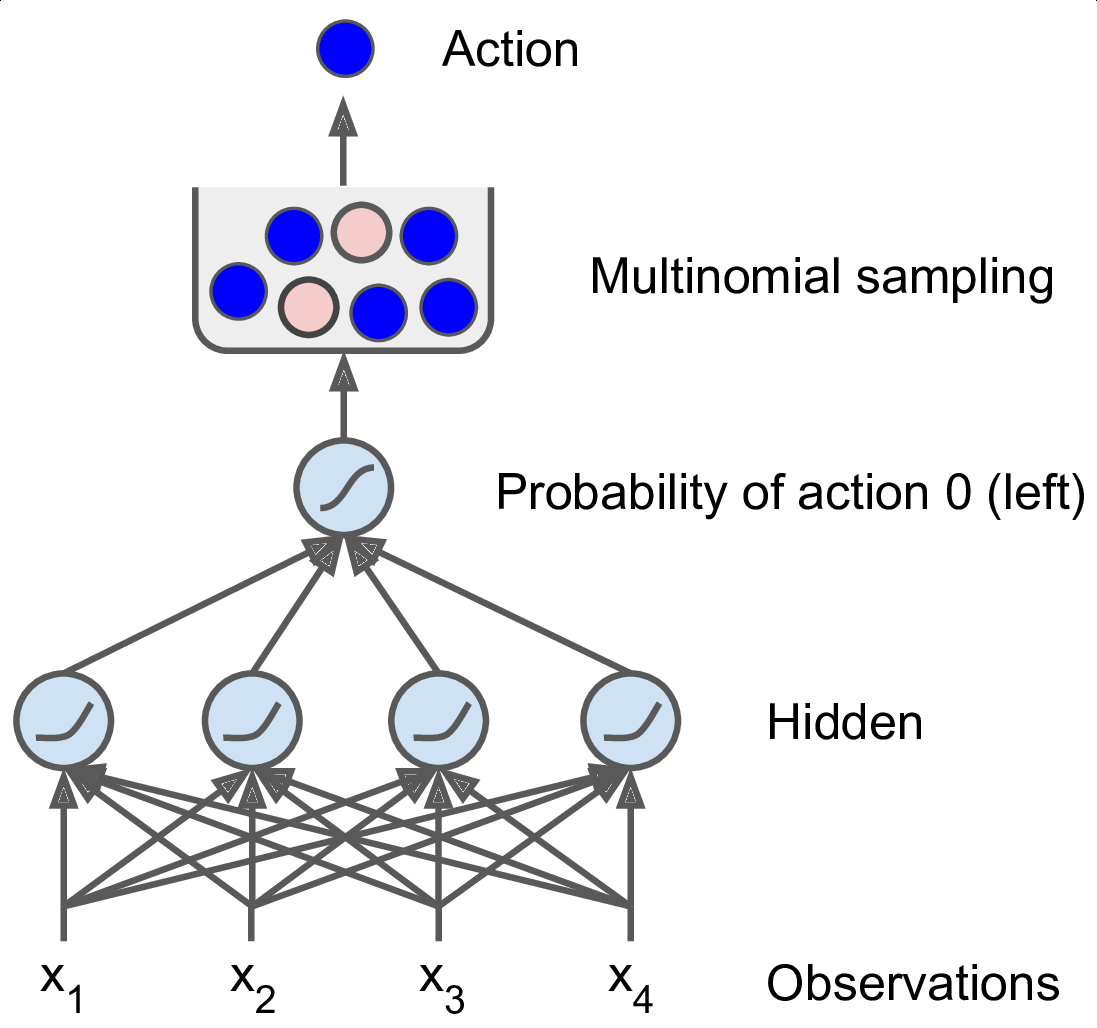

In [6]:
from IPython.display import Image 
# figure from book Hands-on ML with skl and tf
Image("getfile.png")

In [7]:
##This neural network will take an observation as input, 
#and it will output the action to be executed

In [8]:
env = gym.make("CartPole-v0")
obs = env.reset()
obs

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


array([ 0.00403809, -0.03510841, -0.00383652, -0.04021957])

In [9]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [10]:
openai_cart_pole_rendering = False

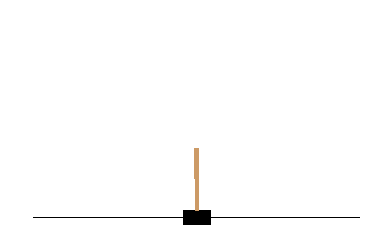

In [11]:
plot_cart_pole(env, obs)

In [12]:
#The number of inputs is the size of the observation space 
#(which in the case of the CartPole is four), 
#we just have four hidden units and no need for more, 
#and we have just one output probability 
#(the probability of going left).

In [13]:
#There are just two possible actions (left or right), 
#so we only need one output neuron. It will output 
#the probability p of action 0 (left), and of course the 
#probability of action 1 (right) will be 1 – p. For example, 
#if it outputs 0.7, then we will pick action 0 
#with 70% probability, and action 1 with 30% probability.

In [14]:
# env.obervation_space.shape[0]
n_inputs = 4 
# it's a simple task, we dont need more hidden neurons
n_hidden = 4 #
#only outputs the probability of accelerating left 
n_outputs =1 #
initilaizer = tf.contrib.layers.variance_scaling_initializer()

In [15]:
# build the network
# placeholder
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [16]:
# Store layers weight
weights = {
    'h1': tf.Variable(tf.random_normal([n_inputs,n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_outputs]))
}

In [17]:
# Store layers bias
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_outputs]))
}

In [18]:
# hiddden layer
hidden = tf.add(tf.matmul(X, weights['h1']), biases['b1'])
hidden = tf.nn.relu(hidden)

In [19]:
logits = tf.matmul(hidden, weights['out']) + biases['out']

In [20]:
#The output layer uses the logistic (sigmoid) activation function 
#in order to output a probability from 0.0 to 1.0. 
#If there were more than two possible actions, 
#there would be one output neuron per action, 
#and you would use the softmax activation function instead.

In [21]:
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)

In [22]:
# for tensorflow 1.0
#net = tf.concat(3, [branch_0, branch_1, branch_2, branch_3]) 

In [23]:
# select a random action based on the estimated probabilities 

p_left_and_right = tf.concat(1, [outputs,1 - outputs])
#multinomial() function to pick a random action
#This function independently samples one (or more) integers,
#given the log probability of each integer
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

In [24]:
#Since the outputs tensor only contains the probability 
#of going left, we must first concatenate 1-outputs to 
#it to have a tensor containing the probability of both 
#left and right actions. Note that if there were more than 
#two possible actions, the neural network would have 
#to output one probability per action so you would 
#not need the concatenation step.

In [25]:
init = tf.initialize_all_variables()

In [26]:
#action 0 (left) and 0.0 if it is action 1 (right):
y = 1. -tf.to_float(action)

In [27]:
#target=y 0.11 tensorflow 
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(targets=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

In [28]:
init = tf.initialize_all_variables()

In [29]:
saver = tf.train.Saver()

In [30]:
#Let's randomly initialize this policy neural network and use it to play one game:

#def render_policy_net(model_path, action, X, n_max_steps = 1000):
#    frames = []
#    env = gym.make("CartPole-v0")
#    obs = env.reset()
#    with tf.Session() as sess:
#        saver.restore(sess, model_path)
#        for step in range(n_max_steps):
#            img = render_cart_pole(env, obs)
#            frames.append(img)
#            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
#            obs, reward, done, info = env.step(action_val[0][0])
#            if done:
#                break
#    env.close()
#    return frames

In [31]:
# display learning result 
#frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
#video = plot_animation(frames)
#plt.show()

In [32]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        ###
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        ##
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


In [33]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

In [38]:
#frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
#video = plot_animation(frames)
#plt.show()